# Intro & Problem Understanding

## Assurance of Learning Artificial Intelligence
Emas (XAU/USD) merupakan salah satu komoditas yang paling banyak diperdagangkan dan sangat dipengaruhi oleh volatilitas global, gejolak ekonomi, dan sentimen pasar. Memprediksi pergerakan harga emas secara akurat dapat memberikan keuntungan signifikan bagi trader dan investor.

Namun, harga emas sangat dinamis dan dipengaruhi oleh banyak faktor eksternal, sehingga metode prediksi konvensional sering kali tidak cukup. Oleh karena itu, dalam proyek ini kami menggunakan **Long Short-Term Memory (LSTM)** — model deep learning yang unggul dalam menangani data sequential seperti time series — untuk memprediksi harga emas berdasarkan data historis.

---

### 🎯 Tujuan
- Membangun model LSTM yang dapat memprediksi harga emas (XAU/USD) dengan akurasi tinggi.
- Menggunakan data historis harga emas selama **120 hari** dengan **timeframe M15**.
- Mengoptimalkan performa model menggunakan teknik seperti Dropout dan EarlyStopping untuk menghindari overfitting.
- Mengevaluasi performa model dengan visualisasi dan metrik regresi seperti RMSE dan R².
- Mengekspor model ke ONNX agar dapat digunakan dalam platform trading seperti **MetaTrader 5**.

---

### 🤖 Tools
- Python, TensorFlow/Keras
- MetaTrader 5 (untuk data collection)

---

### 👥 Tim
| Nama                  | NIM        |
|-----------------------|------------|
| Muhammad Iqbal Saputra | 2702390236 |
| Angelino Delvin        | 2802526271 |
| Marvell Maxwell        | 2802472685 |

# Libraries

In [3]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras import backend as K
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.metrics import RootMeanSquaredError as rmse
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model
from keras import optimizers
import MetaTrader5 as mt5
from datetime import datetime, timedelta
import time                              
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import r2_score, confusion_matrix, accuracy_score, classification_report
import tf2onnx
from sys import argv
import gc
# import mplfinance as mpf

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Cek versi TensorFlow
print(f"Versi TensorFlow:",tf.__version__)

# Cek apakah GPU tersedia
if tf.config.list_physical_devices('GPU'):
    print("GPU tersedia")
else:
    print("GPU tidak tersedia, menggunakan CPU")
    
gpu_device = tf.config.experimental.list_physical_devices('GPU')
print(f"Number of GPU = {len(gpu_device)}")
tf.config.experimental.set_memory_growth(gpu_device[0], True)

Versi TensorFlow: 2.10.0
GPU tersedia
Number of GPU = 1


# Data Collection

In [5]:
# Menginisialisasi koneksi ke MetaTrader5
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()
    
# Show terminal info
terminal_info=mt5.terminal_info()
print(terminal_info)


TerminalInfo(community_account=False, community_connection=False, connected=True, dlls_allowed=True, trade_allowed=True, tradeapi_disabled=False, email_enabled=False, ftp_enabled=False, notifications_enabled=False, mqid=True, build=4885, maxbars=100000, codepage=0, ping_last=22495, community_balance=0.0, retransmission=0.8698129332447062, company='MetaQuotes Ltd.', name='MetaTrader 5', language='English', path='C:\\Program Files\\MetaTrader 5', data_path='C:\\Users\\miqba\\AppData\\Roaming\\MetaQuotes\\Terminal\\D0E8209F77C8CF37AD8BF550E51FF075', commondata_path='C:\\Users\\miqba\\AppData\\Roaming\\MetaQuotes\\Terminal\\Common')


In [6]:
# Tanggal mulai dan akhir untuk pengambilan data
end_date = datetime.now()
start_date = end_date - timedelta(days=120)

# Cek apakah tanggal mulai lebih awal dari tanggal akhir
print("data start date =",start_date)
print("data end date =",end_date)

data start date = 2025-02-05 14:33:29.258102
data end date = 2025-06-05 14:33:29.258102


In [5]:
# Ambil data harga XAUUSD (Timeframe M15) dari MT5
xauusd_rates = mt5.copy_rates_range("XAUUSD", mt5.TIMEFRAME_M15, start_date, end_date)

In [6]:
# Bikin DataFrame dari data yang diambil
df = pd.DataFrame(xauusd_rates)
df['time'] = pd.to_datetime(df['time'], unit='s') # Ubah timestamp ke datetime
df.set_index('time', inplace=True)

# Cek beberapa baris awal dan akhir DataFrame
print("\nDataFrame Head:")
print(df.head())
print("\nDataFrame Tail:")
print(df.tail())
print(f"\nDataFrame Shape: {df.shape}")


DataFrame Head:
                        open     high      low    close  tick_volume  spread  \
time                                                                           
2025-02-04 11:45:00  2819.40  2821.81  2819.06  2820.09         1074       5   
2025-02-04 12:00:00  2819.95  2819.98  2816.01  2816.52          990       5   
2025-02-04 12:15:00  2816.45  2816.95  2815.43  2816.15         1075       5   
2025-02-04 12:30:00  2816.11  2816.44  2812.86  2814.32         1122       5   
2025-02-04 12:45:00  2814.26  2815.41  2813.33  2814.98          946       5   

                     real_volume  
time                              
2025-02-04 11:45:00            0  
2025-02-04 12:00:00            0  
2025-02-04 12:15:00            0  
2025-02-04 12:30:00            0  
2025-02-04 12:45:00            0  

DataFrame Tail:
                        open     high      low    close  tick_volume  spread  \
time                                                                           


In [7]:
# Simpan data ke CSV
df.to_csv("XAUUSD_M15_DATA.csv", index=False)  

# Exploratory Data Analysis


In [8]:
# Define DataFrame untuk XAUUSD rates
df = pd.DataFrame(xauusd_rates)

# Cek beberapa baris awal DataFrame
df.head()

,time,open,high,low,close,tick_volume,spread,real_volume
0,1738669500,2819.40,2821.81,2819.06,2820.09,1074,5,0
1,1738670400,2819.95,2819.98,2816.01,2816.52,990,5,0
2,1738671300,2816.45,2816.95,2815.43,2816.15,1075,5,0
3,1738672200,2816.11,2816.44,2812.86,2814.32,1122,5,0
4,1738673100,2814.26,2815.41,2813.33,2814.98,946,5,0


In [9]:
# Cek beberapa baris akhir DataFrame
df.tail()

,time,open,high,low,close,tick_volume,spread,real_volume
7790,1749033000,3361.40,3365.28,3359.87,3360.54,1015,17,0
7791,1749033900,3360.52,3361.51,3353.68,3354.63,1152,17,0
7792,1749034800,3354.49,3357.28,3351.80,3355.71,1309,17,0
7793,1749035700,3355.71,3356.74,3353.91,3355.08,927,16,0
7794,1749036600,3355.14,3360.23,3355.09,3360.13,962,5,0


In [10]:
# Cek bentuk DataFrame
df.shape

(7795, 8)

In [11]:
# Cek deskripsi statistik dari DataFrame
df.describe()

,time,open,high,low,close,tick_volume,spread,real_volume
count,7.795000e+03,7795.000000,7795.000000,7795.000000,7795.000000,7795.000000,7795.000000,7795.0
mean,1.743817e+09,3112.484268,3115.138177,3109.764640,3112.559497,979.784990,11.287107,0.0
std,3.015047e+06,180.101164,180.687667,179.450028,180.092129,289.686754,5.062472,0.0
min,1.738670e+09,2814.130000,2815.410000,2812.860000,2814.170000,94.000000,0.000000,0.0
25%,1.741199e+09,2928.695000,2930.480000,2926.860000,2928.690000,820.500000,6.000000,0.0
50%,1.743719e+09,3094.000000,3099.440000,3090.280000,3094.930000,1002.000000,12.000000,0.0
75%,1.746503e+09,3295.575000,3298.630000,3292.560000,3295.625000,1168.000000,15.000000,0.0
max,1.749037e+09,3497.360000,3499.980000,3489.180000,3497.330000,1966.000000,90.000000,0.0


In [12]:
# Cek info dari DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7795 entries, 0 to 7794
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         7795 non-null   int64  
 1   open         7795 non-null   float64
 2   high         7795 non-null   float64
 3   low          7795 non-null   float64
 4   close        7795 non-null   float64
 5   tick_volume  7795 non-null   uint64 
 6   spread       7795 non-null   int32  
 7   real_volume  7795 non-null   uint64 
dtypes: float64(4), int32(1), int64(1), uint64(2)
memory usage: 456.9 KB


In [13]:
# Cek apakah ada nilai yang hilang (NaN)
df.isnull().sum()  

time           0
open           0
high           0
low            0
close          0
tick_volume    0
spread         0
real_volume    0
dtype: int64

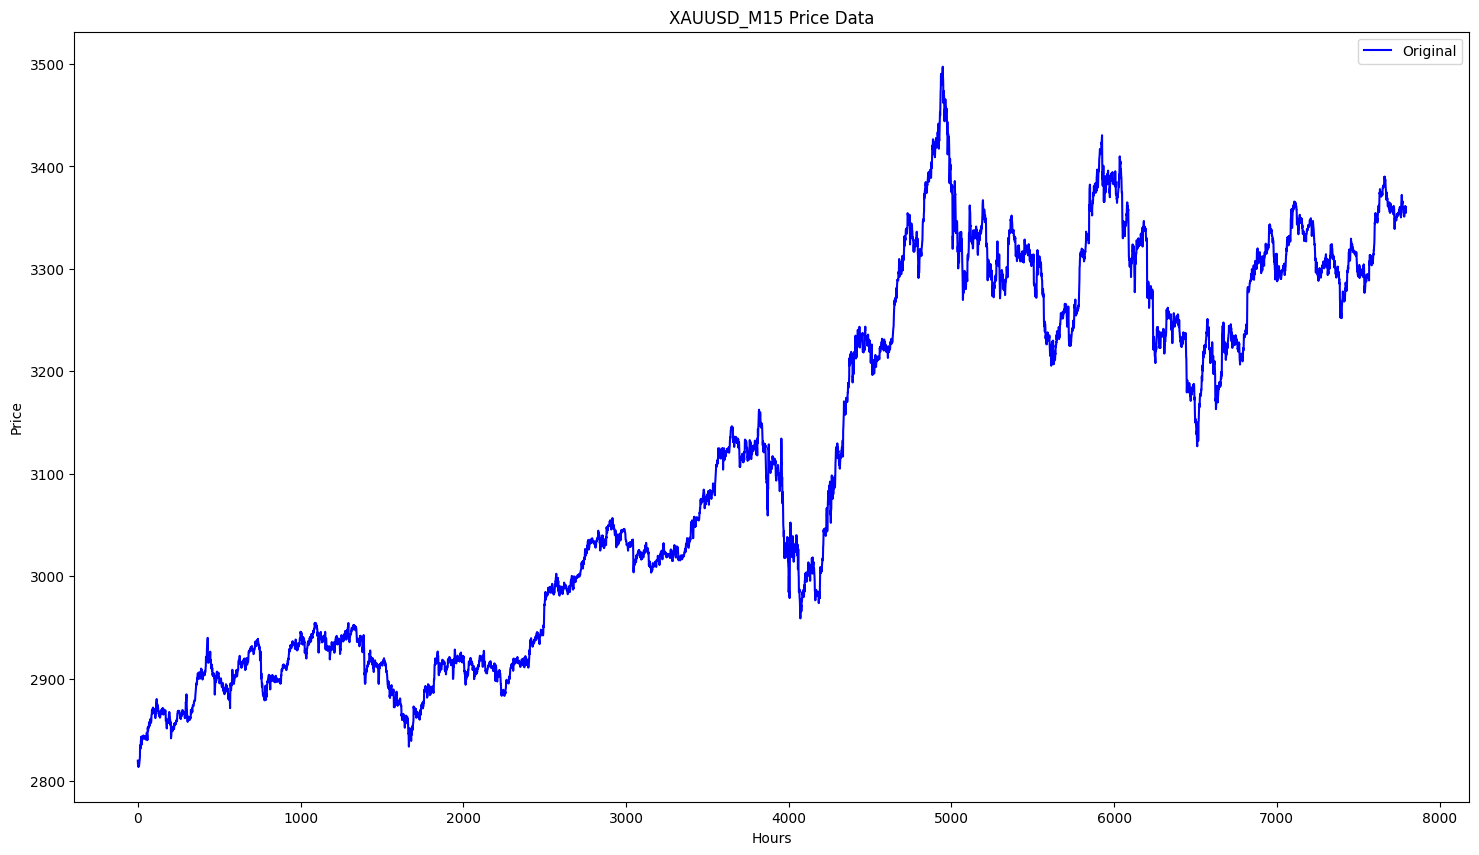

In [14]:
# Tampilkan beberapa informasi dasar tentang DataFrame
plt.figure(figsize = (18,10))
plt.plot(df['close'],'b',label = 'Original')
plt.xlabel("Hours")
plt.ylabel("Price")
plt.title("XAUUSD_M15 Price Data")
plt.legend()

In [15]:
# Cek Duplikasi pada Indeks Waktu
duplicates = df.index.duplicated().sum()
duplicates


0

In [16]:
# Cek Jeda Waktu (Gaps) pada Data
# Menghitung selisih waktu antar baris
time_diff = df.index.to_series().diff()

# Memastikan time_diff adalah tipe timedelta64[ns]
time_diff = time_diff.astype('timedelta64[ns]')

# Hitung selisih dalam jam (float)
time_diff_hours = time_diff.dt.total_seconds() / 3600
TOLERANCE_FOR_NORMAL_INTERVAL = 0.0001 # dalam jam
significant_gaps = time_diff_hours[
    (time_diff_hours < (1.0 - TOLERANCE_FOR_NORMAL_INTERVAL)) |
    (time_diff_hours > (1.0 + TOLERANCE_FOR_NORMAL_INTERVAL))
].dropna()

significant_gaps = significant_gaps[significant_gaps.abs() > 0.001].dropna() # Anggap gap jika lebih dari 0.001 jam (3.6 detik)

if not significant_gaps.empty:
    print(significant_gaps.head(10)) # Tampilkan 10 contoh gap
else:
    print("Tidak ada gap/anomali waktu yang signifikan di data (selain jeda pasar yang normal atau perbedaan presisi waktu yang sangat kecil).")

Tidak ada gap/anomali waktu yang signifikan di data (selain jeda pasar yang normal atau perbedaan presisi waktu yang sangat kecil).


In [17]:
# Drop kolom `real_volume`
if 'real_volume' in df.columns:
    if df['real_volume'].sum() == 0:
        df_eda = df.drop(columns=['real_volume'])
    else:
        df_eda = df.copy()
else:
    df_eda = df.copy()


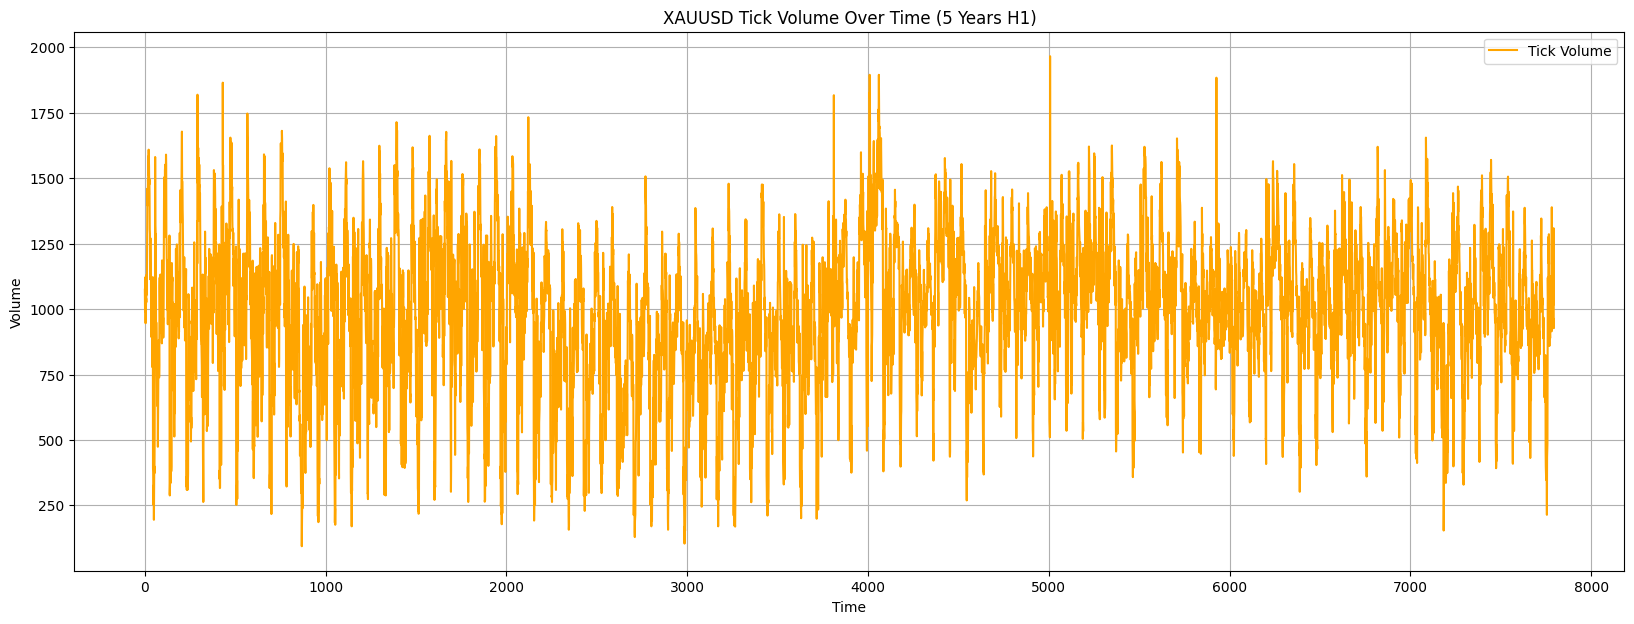

In [18]:
# Plot Tick Volume
plt.figure(figsize=(20, 7))
plt.plot(df_eda['tick_volume'], label='Tick Volume', color='orange')
plt.title('XAUUSD Tick Volume Over Time (5 Years H1)')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

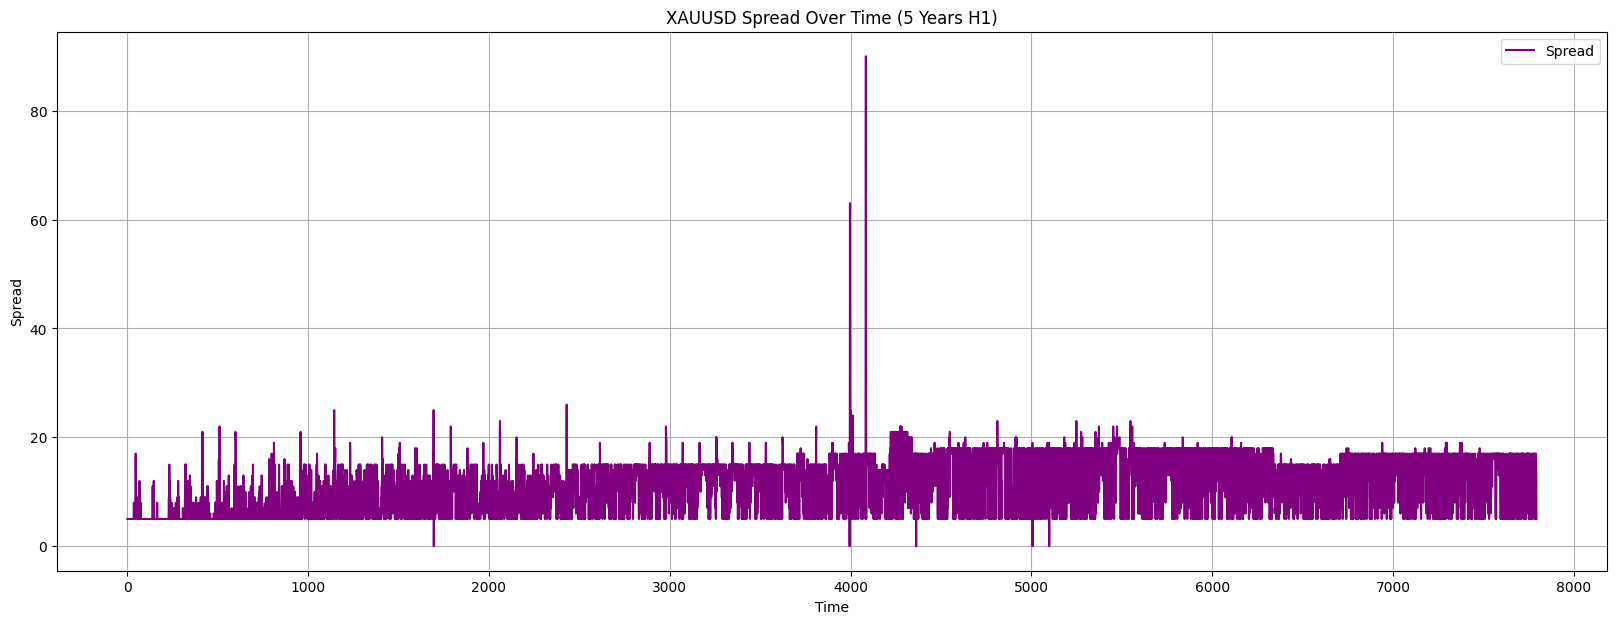

In [19]:
# Plot Spread
plt.figure(figsize=(20, 7))
plt.plot(df_eda['spread'], label='Spread', color='purple')
plt.title('XAUUSD Spread Over Time (5 Years H1)')
plt.xlabel('Time')
plt.ylabel('Spread')
plt.legend()
plt.grid(True)
plt.show()

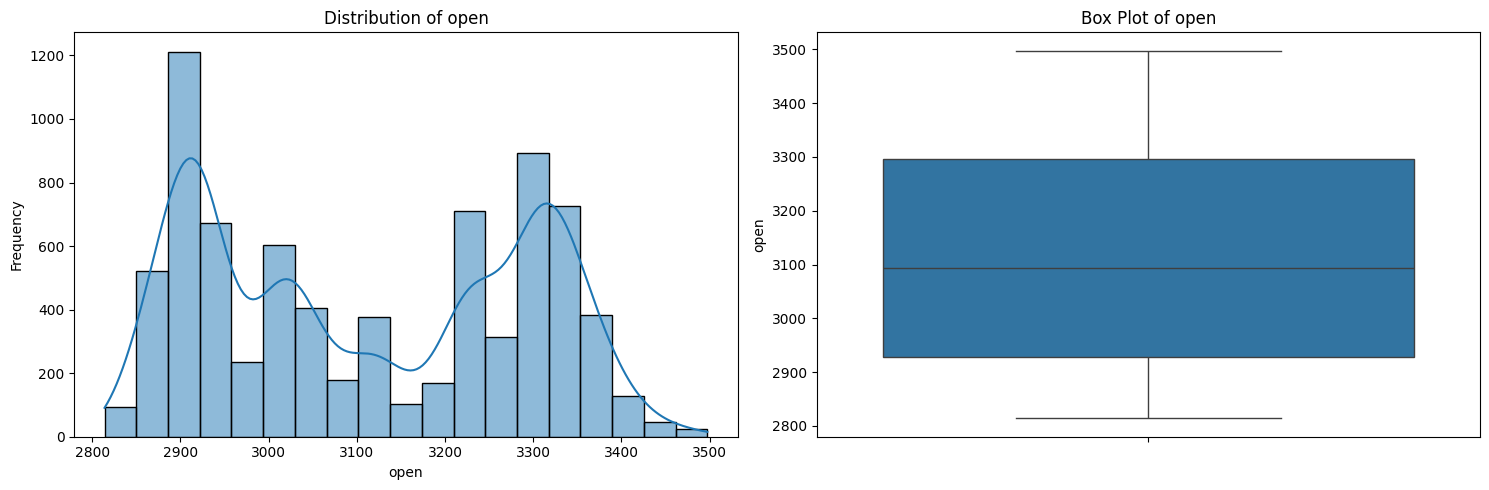

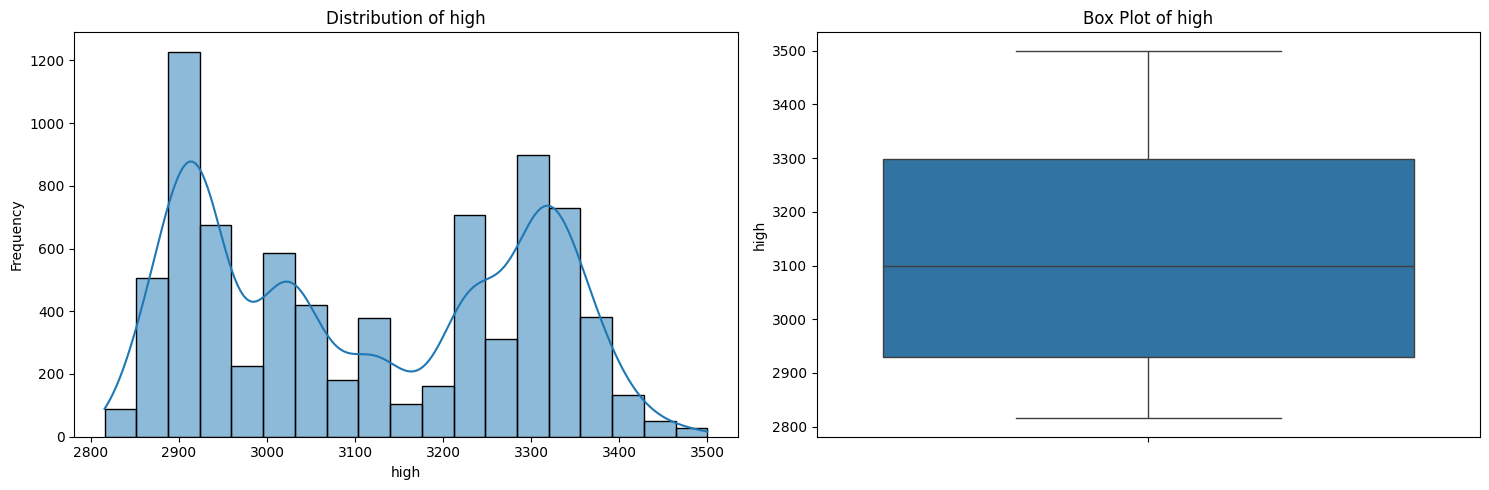

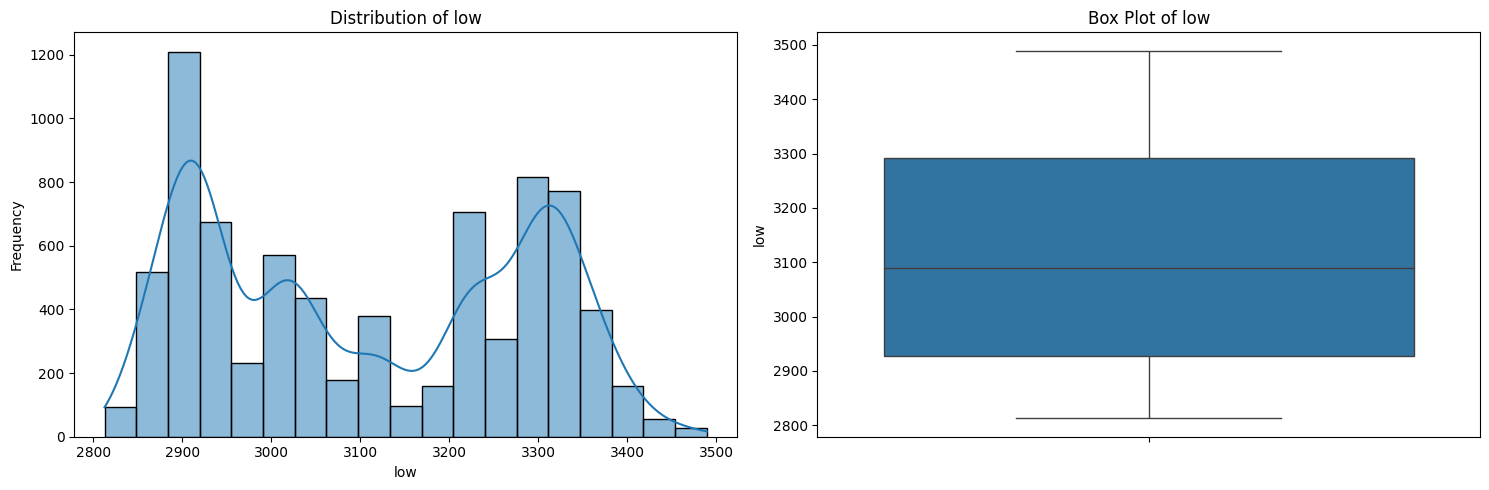

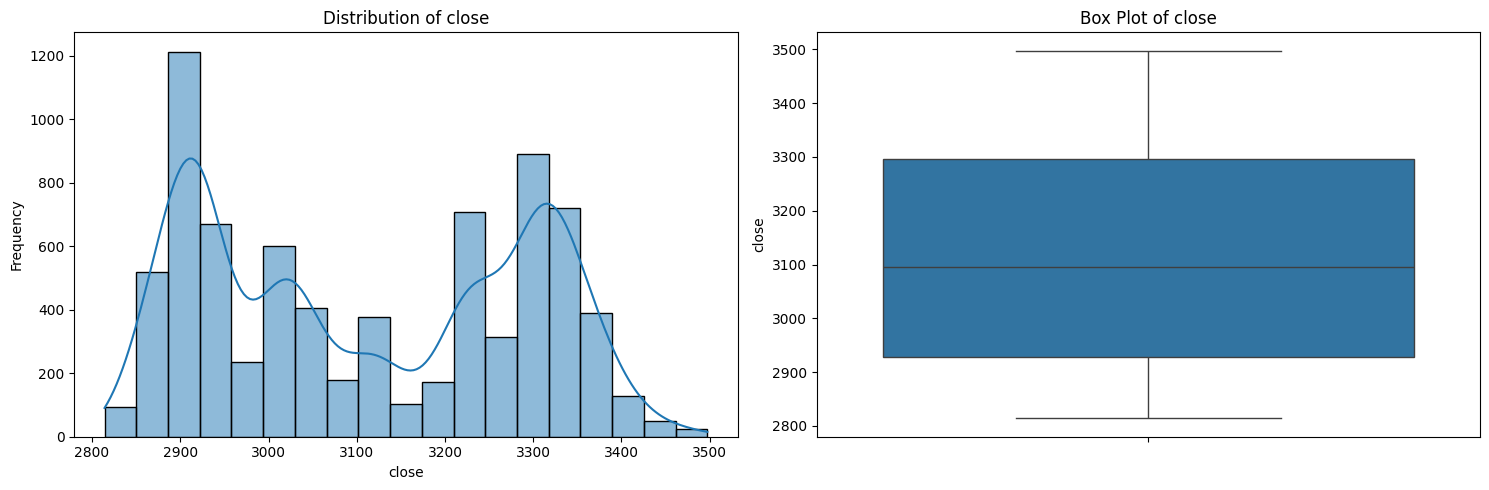

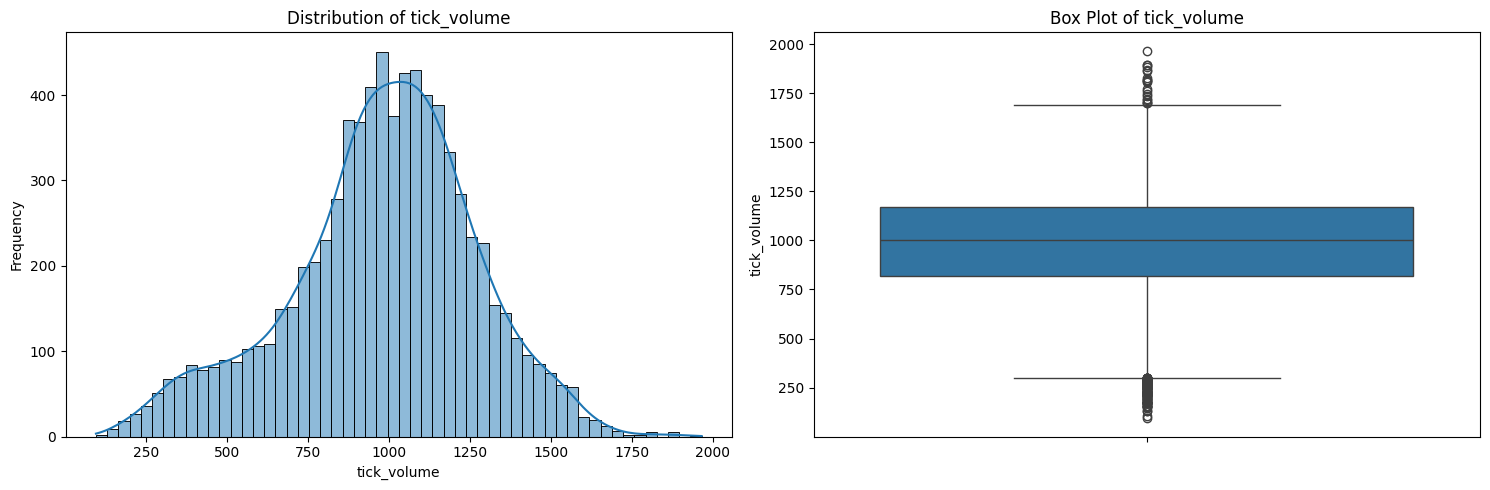

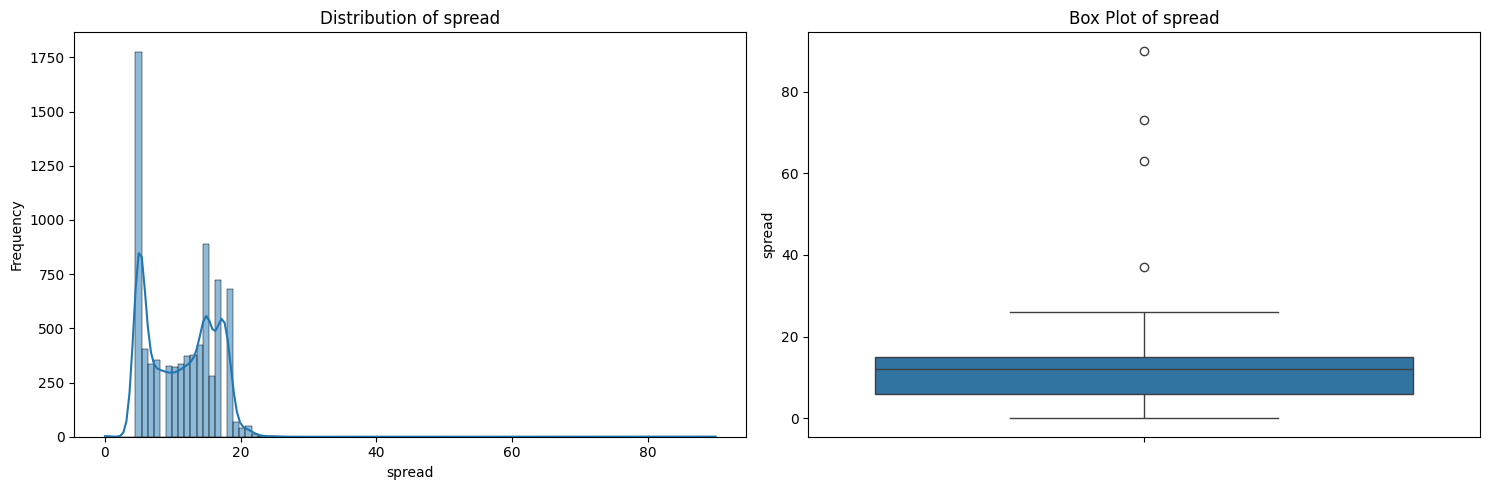

In [20]:
# Histogram dan Box Plot untuk Setiap Fitur Numerik

# Pilih kolom-kolom numerik yang relevan 
numerical_cols = ['open', 'high', 'low', 'close', 'tick_volume', 'spread']

for col in numerical_cols:
    plt.figure(figsize=(15, 5))

    # Histogram
    plt.subplot(1, 2, 1) # 1 baris, 2 kolom, plot ke-1
    sns.histplot(df_eda[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # Box Plot
    plt.subplot(1, 2, 2) # 1 baris, 2 kolom, plot ke-2
    sns.boxplot(y=df_eda[col])
    plt.title(f'Box Plot of {col}')
    plt.ylabel(col)

    plt.tight_layout() # Untuk menyesuaikan layout agar tidak tumpang tindih
    plt.show()

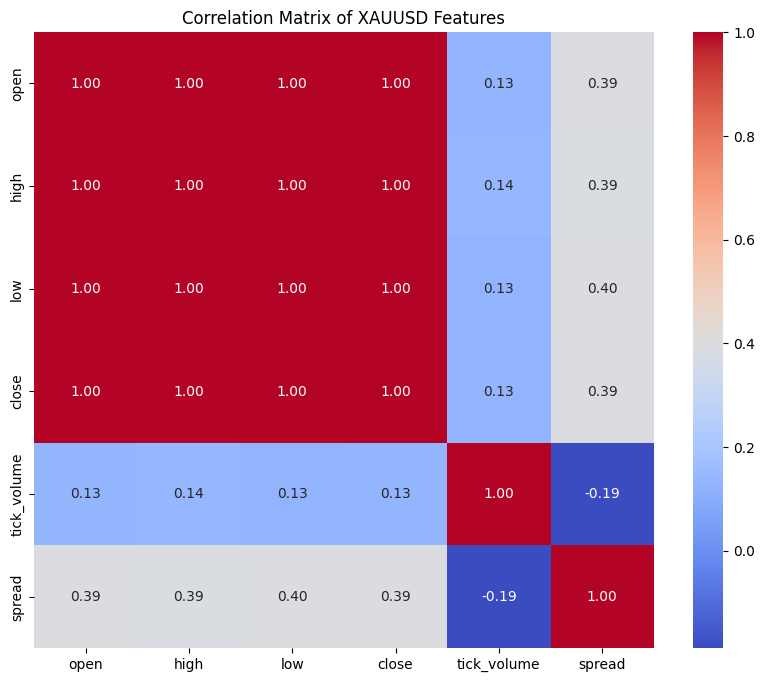

In [21]:
# Correlation Matrix Heatmap
correlation_matrix = df_eda[numerical_cols].corr()

# Buat heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of XAUUSD Features')
plt.show()

# Preprocessing

In [22]:
# # Drop 'real_volume'
if 'real_volume' in df.columns and df['real_volume'].sum() == 0:
    df_processed = df.drop(columns=['real_volume'])
else:
    df_processed = df.copy()

In [23]:
# Define fitur-fitur yang akan digunakan
features_for_modeling = ['open', 'high', 'low', 'close', 'tick_volume', 'spread']
df_features = df_processed[features_for_modeling].copy()

In [24]:
# Transform log1p pada 'tick_volume' dan 'spread'
df_features['tick_volume'] = np.log1p(df_features['tick_volume'])
df_features['spread'] = np.log1p(df_features['spread'])

In [25]:
# Split data menjadi train dan test
train_size = int(len(df_features) * 0.8)
df_train = df_features.iloc[:train_size]
df_test = df_features.iloc[train_size:]
print(f"Train set shape: {df_train.shape}, Test set shape: {df_test.shape}")

Train set shape: (6236, 6), Test set shape: (1559, 6)


In [26]:
scaler_features = MinMaxScaler()
train_scaled = scaler_features.fit_transform(df_train.values)
test_scaled = scaler_features.transform(df_test.values)

In [27]:
# Scaling data menggunakan MinMaxScaler
scaler_close = MinMaxScaler()
scaler_close.fit(df_train[['close']].values)

MinMaxScaler()

In [28]:
# # Define fungsi split_sequence untuk sliding window
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    target_column_index = features_for_modeling.index('close')
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix, :], sequence[end_ix, target_column_index]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [29]:
# Define jumlah langkah waktu (n_steps) untuk input model
time_step = 120
x_train, y_train = split_sequence(train_scaled, time_step)
x_test, y_test = split_sequence(test_scaled, time_step)

# Reshape input untuk LSTM: [samples, time steps, features]
num_features = len(features_for_modeling)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], num_features)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], num_features)

print(f"Bentuk x_train: {x_train.shape}")
print(f"Bentuk y_train: {y_train.shape}")
print(f"Bentuk x_test: {x_test.shape}")
print(f"Bentuk y_test: {y_test.shape}")

Bentuk x_train: (6116, 120, 6)
Bentuk y_train: (6116,)
Bentuk x_test: (1439, 120, 6)
Bentuk y_test: (1439,)


# Model Training & Evaluation

## Model 1

In [ ]:
# Clear session dan set seed
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)
K.clear_session()
gc.collect()

34141

: 

In [31]:
# Define model 1
model1 = Sequential()
# Input shape: (x_train.shape[1], num_features)
model1.add(LSTM(32, return_sequences=True, input_shape=(x_train.shape[1], num_features)))
model1.add(Dropout(0.3))
model1.add(LSTM(32))
model1.add(Dropout(0.3))
model1.add(Dense(1, activation='sigmoid')) # target skala 0-1

# Compile Model 1
model1.compile(optimizer='adam', loss='mean_squared_error', metrics=[rmse()])

In [32]:
# Tampilkan ringkasan model
print("\nRingkasan Model 1:")
model1.summary()


Ringkasan Model 1:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 120, 32)           4992      
                                                                 
 dropout (Dropout)           (None, 120, 32)           0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 13,345
Trainable params: 13,345
Non-trainable params: 0
_________________________________________________________________


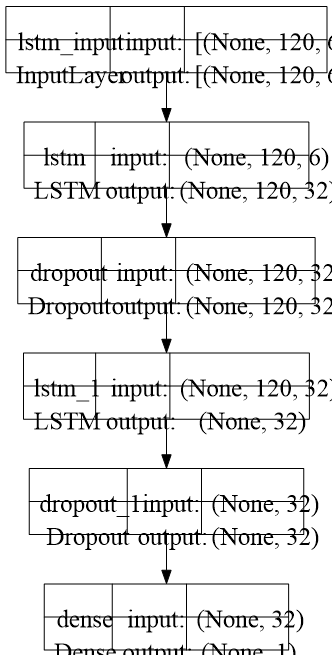

In [33]:
# Plot layers
tf.keras.utils.plot_model(model1, show_shapes=True, show_layer_names=True, to_file='model1_architecture.png')

In [34]:
# Callback EarlyStopping untuk Model 1
early_stop_m1 = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

time_calc_start_m1 = time.time()

# Fit Model 1
print("\nMemulai training Model 1...")
history_m1 = model1.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=300,
    batch_size=32,
    callbacks=[early_stop_m1],
    verbose=1
)

fit_time_seconds_m1 = time.time() - time_calc_start_m1
print(f"\nFit time Model 2 = {fit_time_seconds_m1:.2f} seconds.")


Memulai training Model 1...
Epoch 1/300
192/192 [==============================] - 6s 15ms/step - loss: 0.0064 - root_mean_squared_error: 0.0800 - val_loss: 4.6363e-04 - val_root_mean_squared_error: 0.0215
Epoch 2/300
192/192 [==============================] - 3s 14ms/step - loss: 0.0014 - root_mean_squared_error: 0.0375 - val_loss: 7.7394e-04 - val_root_mean_squared_error: 0.0278
Epoch 3/300
192/192 [==============================] - 3s 13ms/step - loss: 0.0013 - root_mean_squared_error: 0.0354 - val_loss: 3.5030e-04 - val_root_mean_squared_error: 0.0187
Epoch 4/300
192/192 [==============================] - 2s 13ms/step - loss: 0.0011 - root_mean_squared_error: 0.0335 - val_loss: 8.5375e-04 - val_root_mean_squared_error: 0.0292
Epoch 5/300
192/192 [==============================] - 3s 13ms/step - loss: 0.0011 - root_mean_squared_error: 0.0333 - val_loss: 4.6460e-04 - val_root_mean_squared_error: 0.0216
Epoch 6/300
192/192 [==============================] - 3s 13ms/step - loss: 9.549


Visualisasi Loss Curve Model 1:


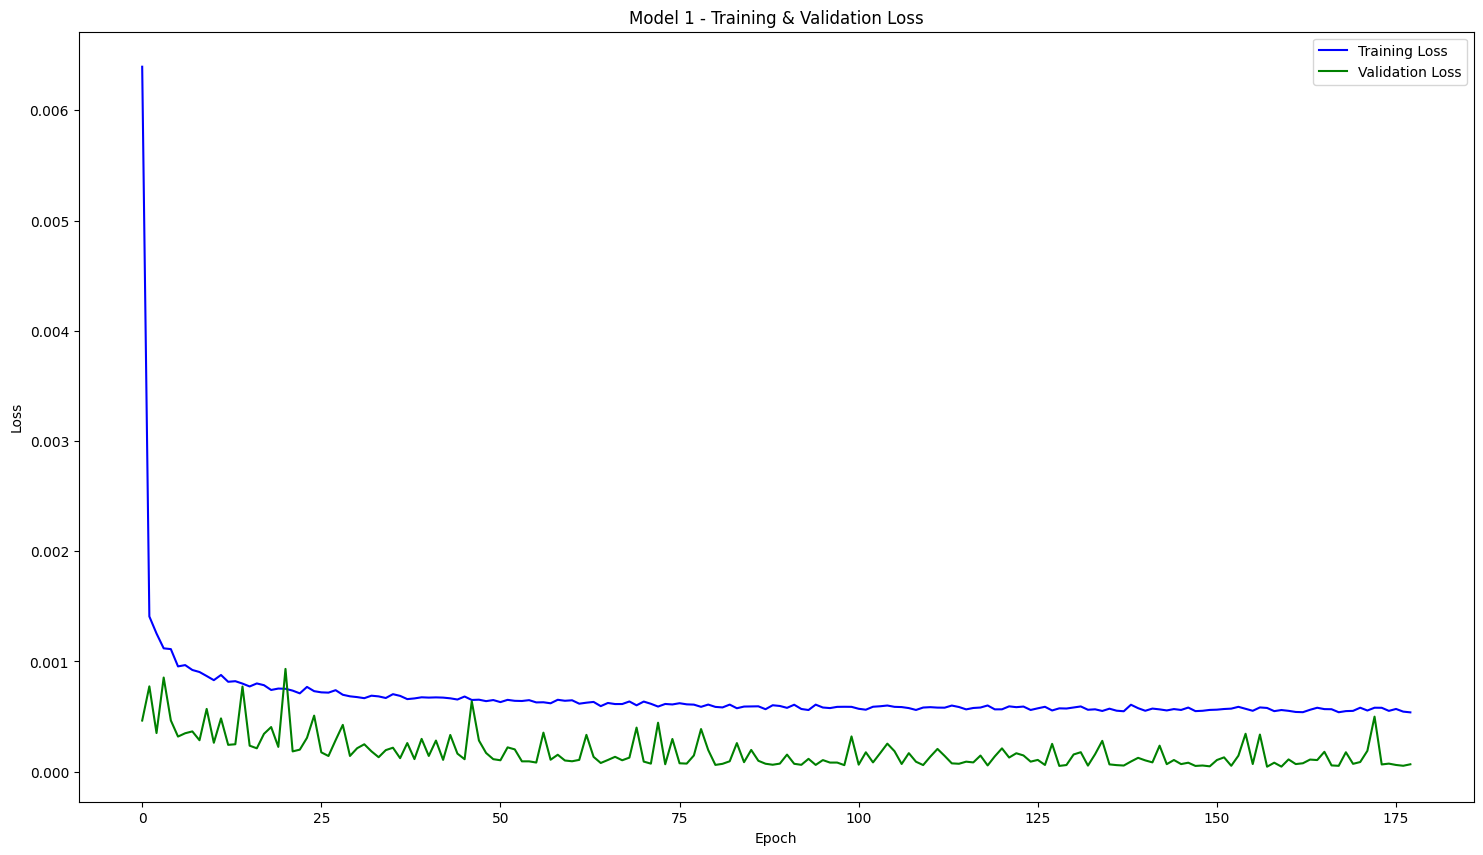

In [35]:
# Loss Curve Model 1
print("\nVisualisasi Loss Curve Model 1:")
plt.figure(figsize = (18,10))
plt.plot(history_m1.history['loss'],label='Training Loss',color='b')
plt.plot(history_m1.history['val_loss'],label='Validation Loss',color='g')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model 1 - Training & Validation Loss")
plt.legend()
plt.show()

In [36]:
# Evaluasi Model 1
print("\nEvaluasi Model 1 pada data training:")
model1.evaluate(x_train, y_train, batch_size=32)
print("\nEvaluasi Model 1 pada data testing:")
model1.evaluate(x_test, y_test, batch_size=32)


Evaluasi Model 1 pada data training:
192/192 [==============================] - 1s 6ms/step - loss: 5.9995e-05 - root_mean_squared_error: 0.0077

Evaluasi Model 1 pada data testing:
45/45 [==============================] - 0s 6ms/step - loss: 4.4657e-05 - root_mean_squared_error: 0.0067


[4.465684469323605e-05, 0.006682577542960644]

In [37]:
# Prediksi dan Inverse Transform untuk Model 1
print("\nMelakukan prediksi dan Inverse Transform untuk Model 1...")
train_predict_m1_scaled = model1.predict(x_train)
test_predict_m1_scaled = model1.predict(x_test)


Melakukan prediksi dan Inverse Transform untuk Model 1...
45/45 [==============================] - 0s 6ms/step


In [38]:
# Inverse transform y_train dan y_test menggunakan scaler_close (sudah dilakukan di Model 1, tapi untuk kejelasan)
y_train_actual_m1 = scaler_close.inverse_transform(y_train.reshape(-1, 1)) 
y_test_actual_m1 = scaler_close.inverse_transform(y_test.reshape(-1, 1))

train_predict_m1_actual = scaler_close.inverse_transform(train_predict_m1_scaled)
test_predict_m1_actual = scaler_close.inverse_transform(test_predict_m1_scaled)

In [39]:
# Hitung metrik Model 1 data train
rmse_train_m1 = np.sqrt(metrics.mean_squared_error(y_train_actual_m1, train_predict_m1_actual)) # Menggunakan y_train_actual_m1/y_test_actual_m1
mse_train_m1 = metrics.mean_squared_error(y_train_actual_m1, train_predict_m1_actual)
r2_train_m1 = r2_score(y_train_actual_m1, train_predict_m1_actual)

# Hitung metrik Model 1 data test
rmse_test_m1 = np.sqrt(metrics.mean_squared_error(y_test_actual_m1, test_predict_m1_actual))
mse_test_m1 = metrics.mean_squared_error(y_test_actual_m1, test_predict_m1_actual)
r2_test_m1 = r2_score(y_test_actual_m1, test_predict_m1_actual)

In [40]:
print("\n--- Metrik Kinerja Model 1 ---")
print(f"Training RMSE: {rmse_train_m1:.4f}")
print(f"Training MSE : {mse_train_m1:.4f}")
print(f"Training R2  : {r2_train_m1:.4f}")
print(f"Testing RMSE : {rmse_test_m1:.4f}")
print(f"Testing MSE  : {mse_test_m1:.4f}")
print(f"Testing R2   : {r2_test_m1:.4f}")


--- Metrik Kinerja Model 1 ---
Training RMSE: 5.2915
Training MSE : 27.9999
Training R2  : 0.9991
Testing RMSE : 4.5653
Testing MSE  : 20.8417
Testing R2   : 0.9938



Visualisasi Prediksi vs Aktual Model 1 (Training Data):


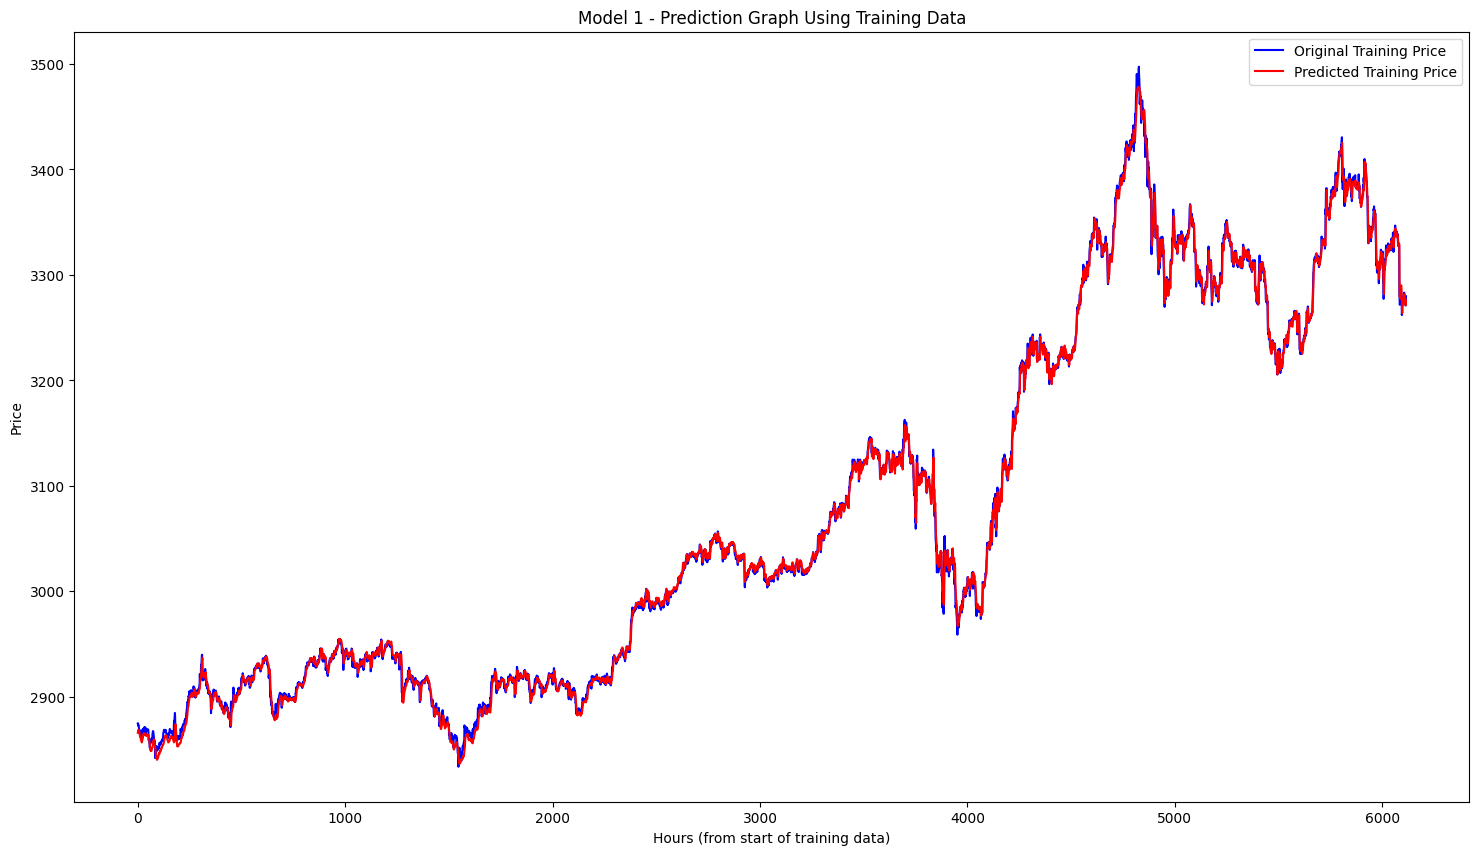

In [41]:
# Visualisasi Prediksi vs Aktual Model 1 (Training Data)
print("\nVisualisasi Prediksi vs Aktual Model 1 (Training Data):")
plt.figure(figsize=(18,10))
plt.plot(y_train_actual_m1, color = 'b', label = 'Original Training Price')
plt.plot(train_predict_m1_actual, color='red', label = 'Predicted Training Price')
plt.title("Model 1 - Prediction Graph Using Training Data")
plt.xlabel("Hours (from start of training data)")
plt.ylabel("Price")
plt.legend()
plt.show()


Visualisasi Prediksi vs Aktual Model 1 (Testing Data):


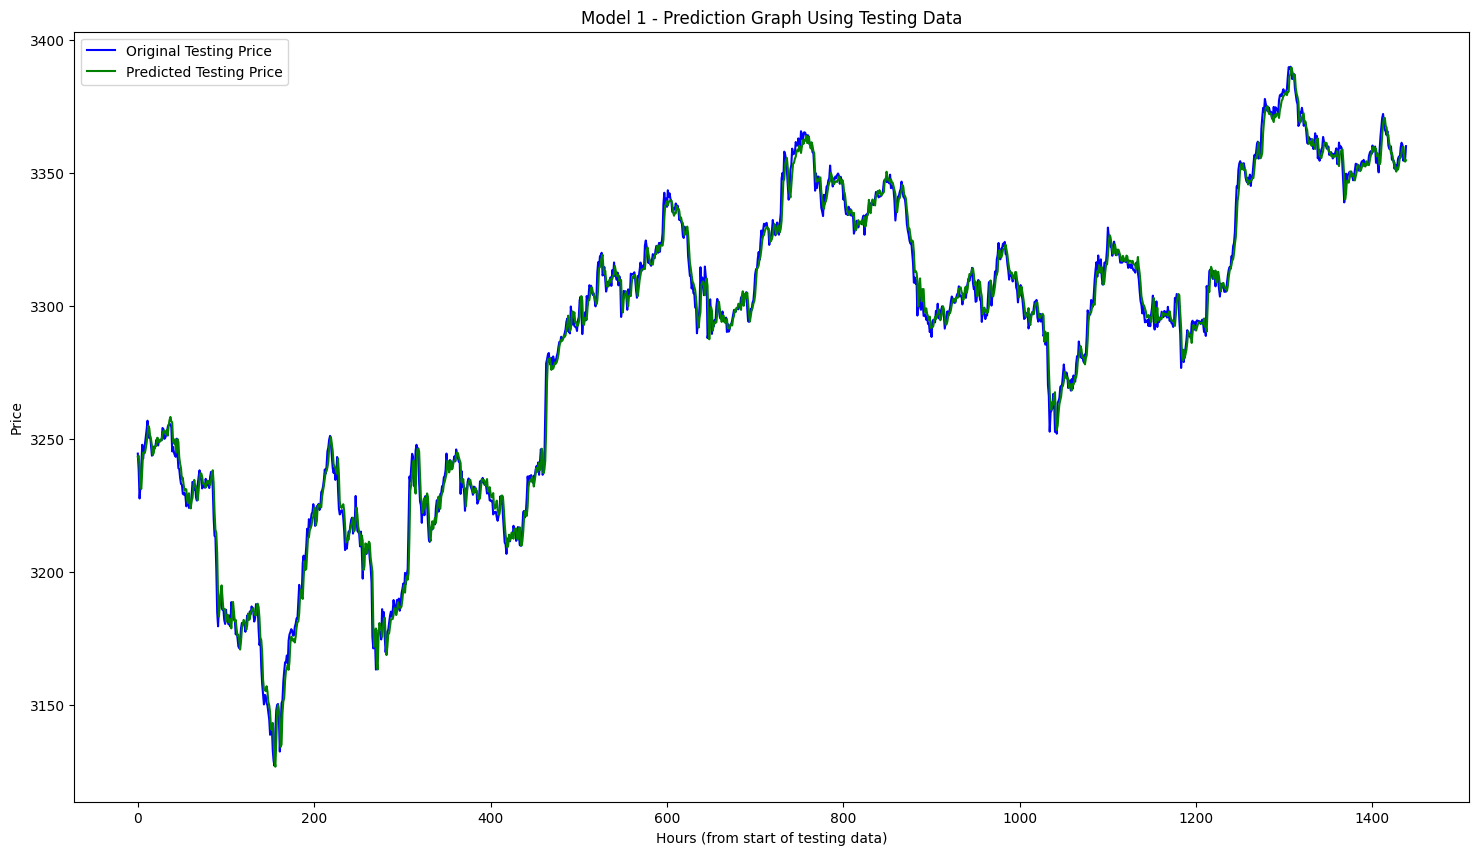

In [42]:
# Visualisasi Prediksi vs Aktual Model 1 (Testing Data)
print("\nVisualisasi Prediksi vs Aktual Model 1 (Testing Data):")
plt.figure(figsize=(18,10))
plt.plot(y_test_actual_m1, color = 'b', label = 'Original Testing Price')
plt.plot(test_predict_m1_actual, color='g', label = 'Predicted Testing Price')
plt.title("Model 1 - Prediction Graph Using Testing Data")
plt.xlabel("Hours (from start of testing data)")
plt.ylabel("Price")
plt.legend()
plt.show()

Confusion Matrix:
 [[374 328]
 [361 375]]
Akurasi prediksi arah: 0.5209
              precision    recall  f1-score   support

           0     0.5088    0.5328    0.5205       702
           1     0.5334    0.5095    0.5212       736

    accuracy                         0.5209      1438
   macro avg     0.5211    0.5211    0.5209      1438
weighted avg     0.5214    0.5209    0.5209      1438



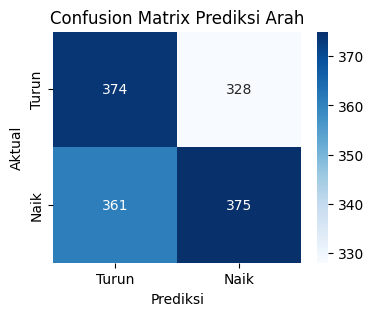

In [43]:
# (Pastikan test_predict_m1 sudah di-inverse dengan scaler_close)
test_predict_m1 = scaler_close.inverse_transform(test_predict_m1_scaled)

y_true = y_test_actual_m1.flatten()
y_pred = test_predict_m1.flatten()

# Prediksi arah (naik/turun)
true_dir = (y_true[1:] > y_true[:-1]).astype(int)
pred_dir = (y_pred[1:] > y_true[:-1]).astype(int)

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true_dir, pred_dir)
acc = accuracy_score(true_dir, pred_dir)

print("Confusion Matrix:\n", cm)
print(f"Akurasi prediksi arah: {acc:.4f}")
print(classification_report(true_dir, pred_dir, digits=4))

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Turun','Naik'], yticklabels=['Turun','Naik'])
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix Prediksi Arah")
plt.show()


## Model 2

In [44]:
# Clear session dan set seed
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)
K.clear_session()
gc.collect()

51823

In [45]:
# Define model 2
model2 = Sequential()
model2.add(LSTM(30, return_sequences=True, input_shape=(x_train.shape[1], num_features))) # Unit lebih sedikit
model2.add(Dropout(0.4)) # Dropout lebih tinggi
model2.add(LSTM(30, return_sequences=False)) # Unit lebih sedikit
model2.add(Dropout(0.4)) # Dropout lebih tinggi
model2.add(Dense(units=1, activation='sigmoid')) # Output 1 unit dengan sigmoid
model2.compile(optimizer='adam', loss='mse', metrics=[rmse()]) # Compile dengan adam, mse, rmse

In [46]:
# Tampilkan ringkasan model
print("\nRingkasan Model 2:")
model2.summary()


Ringkasan Model 2:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 120, 30)           4440      
                                                                 
 dropout (Dropout)           (None, 120, 30)           0         
                                                                 
 lstm_1 (LSTM)               (None, 30)                7320      
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 11,791
Trainable params: 11,791
Non-trainable params: 0
_________________________________________________________________


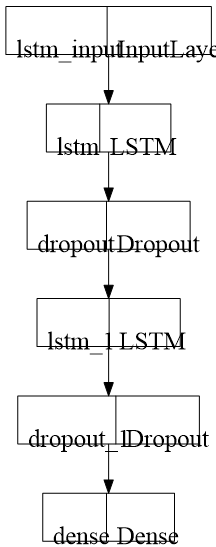

In [47]:
# Plot layers
tf.keras.utils.plot_model(model2, show_layer_names=True,to_file='model2_architecture.png')

In [48]:
# Callback EarlyStopping untuk Model 2
early_stop_m2 = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

time_calc_start_m2 = time.time()

# Fit Model 2
print("\nMemulai training Model 2...")
history_m2 = model2.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=300,
    batch_size=64, # Batch size lebih besar
    callbacks=[early_stop_m2],
    verbose=1
)

fit_time_seconds_m2 = time.time() - time_calc_start_m2
print(f"\nFit time Model 2 = {fit_time_seconds_m2:.2f} seconds.")


Memulai training Model 2...
Epoch 1/300
96/96 [==============================] - 3s 19ms/step - loss: 0.0122 - root_mean_squared_error: 0.1106 - val_loss: 8.3308e-04 - val_root_mean_squared_error: 0.0289
Epoch 2/300
96/96 [==============================] - 1s 15ms/step - loss: 0.0025 - root_mean_squared_error: 0.0496 - val_loss: 3.7159e-04 - val_root_mean_squared_error: 0.0193
Epoch 3/300
96/96 [==============================] - 2s 16ms/step - loss: 0.0019 - root_mean_squared_error: 0.0441 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0318
Epoch 4/300
96/96 [==============================] - 1s 15ms/step - loss: 0.0017 - root_mean_squared_error: 0.0417 - val_loss: 4.8002e-04 - val_root_mean_squared_error: 0.0219
Epoch 5/300
96/96 [==============================] - 1s 15ms/step - loss: 0.0016 - root_mean_squared_error: 0.0399 - val_loss: 5.2913e-04 - val_root_mean_squared_error: 0.0230
Epoch 6/300
96/96 [==============================] - 1s 15ms/step - loss: 0.0016 - root_mean_sq


Visualisasi Loss Curve Model 2:


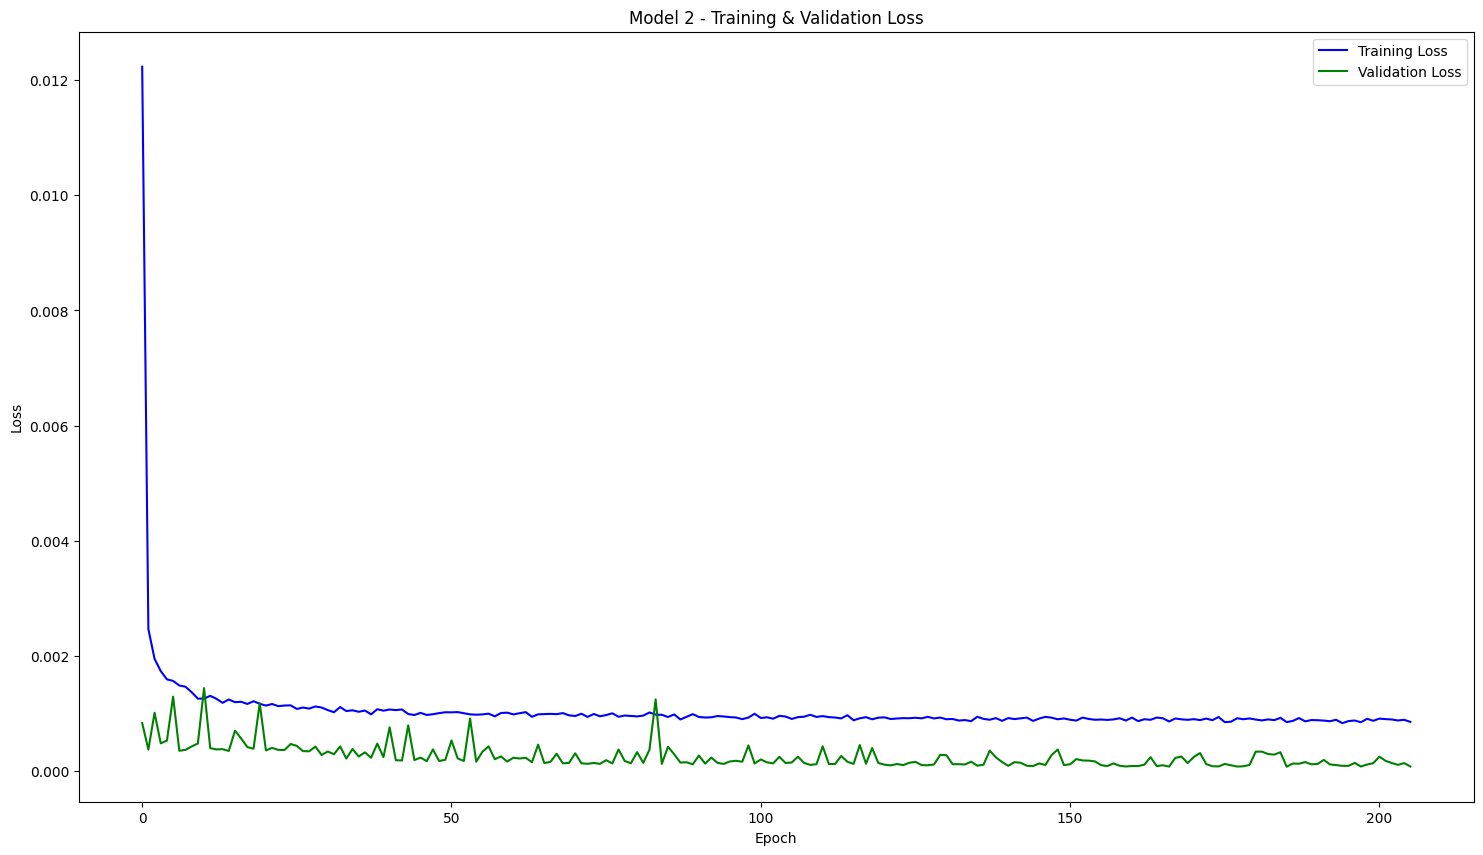

In [49]:
# Loss Curve Model 2
print("\nVisualisasi Loss Curve Model 2:")
plt.figure(figsize = (18,10))
plt.plot(history_m2.history['loss'],label='Training Loss',color='b')
plt.plot(history_m2.history['val_loss'],label='Validation Loss',color='g')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model 2 - Training & Validation Loss")
plt.legend()
plt.show()

In [50]:
# Evaluasi Model 2
print("\nEvaluasi Model 2 pada data training:")
model1.evaluate(x_train, y_train, batch_size=32)
print("\nEvaluasi Model 2 pada data testing:")
model1.evaluate(x_test, y_test, batch_size=32)


Evaluasi Model 2 pada data training:
192/192 [==============================] - 1s 6ms/step - loss: 5.9995e-05 - root_mean_squared_error: 0.0077

Evaluasi Model 2 pada data testing:
45/45 [==============================] - 0s 6ms/step - loss: 4.4657e-05 - root_mean_squared_error: 0.0067


[4.465684469323605e-05, 0.006682577542960644]

In [51]:
# Prediksi dan Inverse Transform untuk Model 2
print("\nMelakukan prediksi dan Inverse Transform untuk Model 2...")
train_predict_m2_scaled = model2.predict(x_train)
test_predict_m2_scaled = model2.predict(x_test)


Melakukan prediksi dan Inverse Transform untuk Model 2...
45/45 [==============================] - 0s 6ms/step


In [52]:
# Inverse transform y_train dan y_test menggunakan scaler_close (sudah dilakukan di Model 1, tapi untuk kejelasan)
y_train_actual_m2 = scaler_close.inverse_transform(y_train.reshape(-1, 1)) 
y_test_actual_m2 = scaler_close.inverse_transform(y_test.reshape(-1, 1))

train_predict_m2_actual = scaler_close.inverse_transform(train_predict_m2_scaled)
test_predict_m2_actual = scaler_close.inverse_transform(test_predict_m2_scaled)

In [53]:
# Hitung metrik Model 2 data train
rmse_train_m2 = np.sqrt(metrics.mean_squared_error(y_train_actual_m2, train_predict_m2_actual)) # Menggunakan y_train_actual_m2/y_test_actual_m2
mse_train_m2 = metrics.mean_squared_error(y_train_actual_m2, train_predict_m2_actual)
r2_train_m2 = r2_score(y_train_actual_m2, train_predict_m2_actual)

# Hitung metrik Model 2 data test
rmse_test_m2 = np.sqrt(metrics.mean_squared_error(y_test_actual_m2, test_predict_m2_actual))
mse_test_m2 = metrics.mean_squared_error(y_test_actual_m2, test_predict_m2_actual)
r2_test_m2 = r2_score(y_test_actual_m2, test_predict_m2_actual)

In [54]:
print("\n--- Metrik Kinerja Model 2 ---")
print(f"Training RMSE: {rmse_train_m2:.4f}")
print(f"Training MSE : {mse_train_m2:.4f}")
print(f"Training R2  : {r2_train_m2:.4f}")
print(f"Testing RMSE : {rmse_test_m2:.4f}")
print(f"Testing MSE  : {mse_test_m2:.4f}")
print(f"Testing R2   : {r2_test_m2:.4f}")


--- Metrik Kinerja Model 2 ---
Training RMSE: 6.8861
Training MSE : 47.4184
Training R2  : 0.9984
Testing RMSE : 5.8742
Testing MSE  : 34.5066
Testing R2   : 0.9897



Visualisasi Prediksi vs Aktual Model 2 (Training Data):


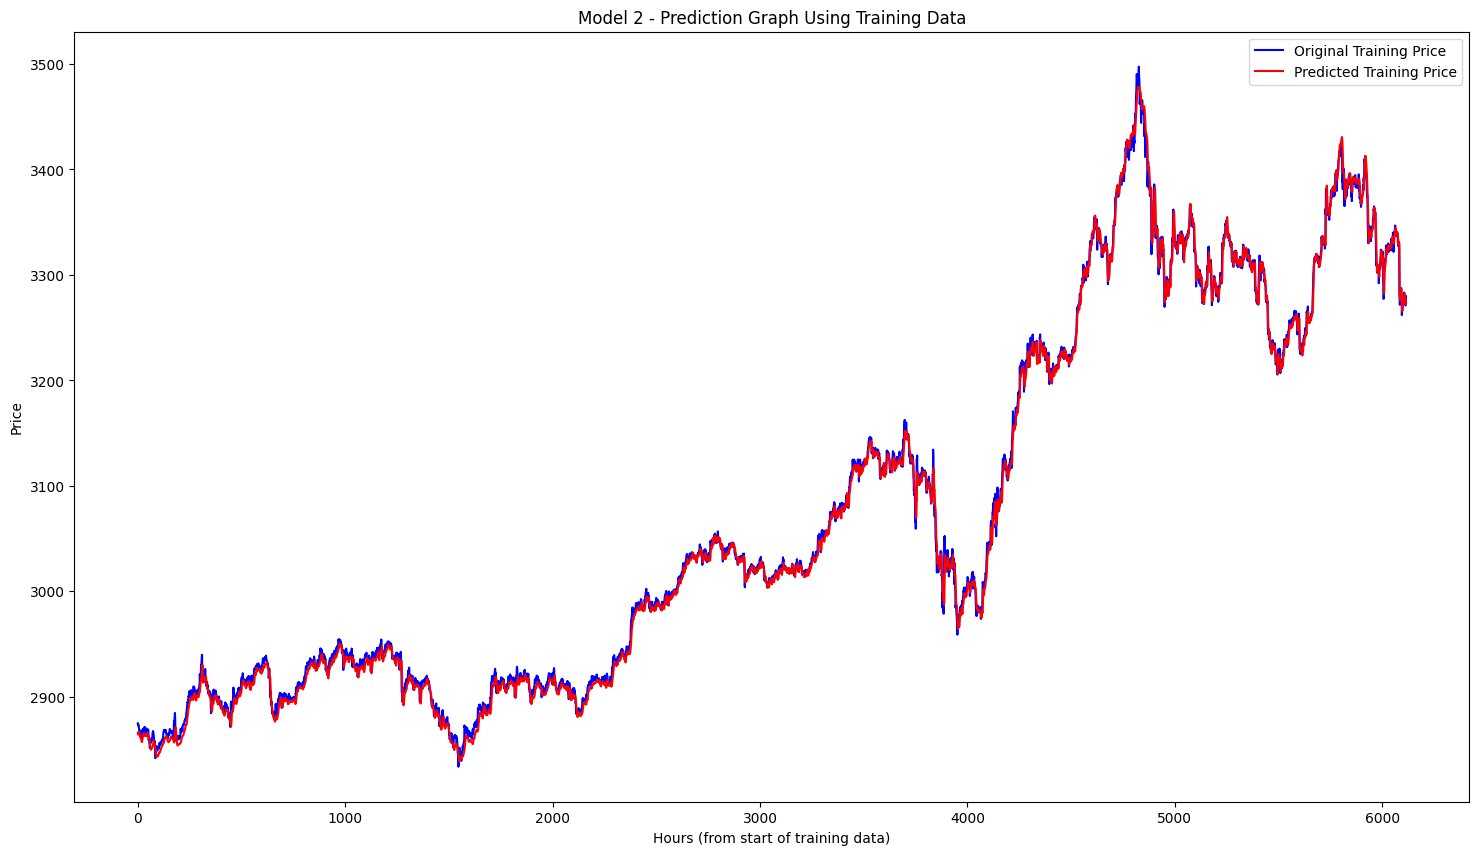

In [55]:
# Visualisasi Prediksi vs Aktual Model 2 (Training Data)
print("\nVisualisasi Prediksi vs Aktual Model 2 (Training Data):")
plt.figure(figsize=(18,10))
plt.plot(y_train_actual_m2, color = 'b', label = 'Original Training Price')
plt.plot(train_predict_m2_actual, color='red', label = 'Predicted Training Price')
plt.title("Model 2 - Prediction Graph Using Training Data")
plt.xlabel("Hours (from start of training data)")
plt.ylabel("Price")
plt.legend()
plt.show()


Visualisasi Prediksi vs Aktual Model 2 (Testing Data):


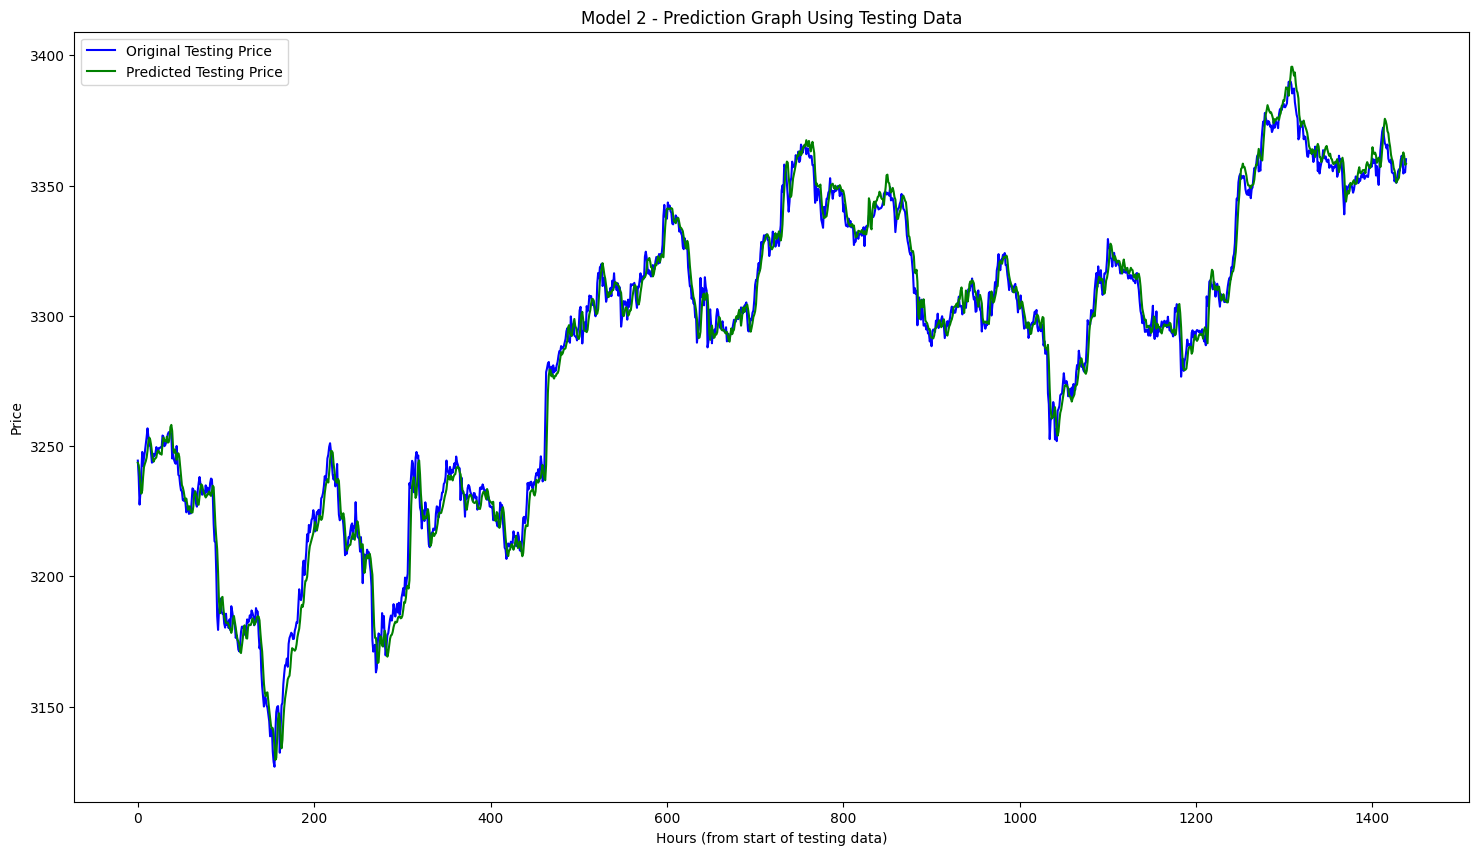

In [56]:
# Visualisasi Prediksi vs Aktual Model 2 (Testing Data)
print("\nVisualisasi Prediksi vs Aktual Model 2 (Testing Data):")
plt.figure(figsize=(18,10))
plt.plot(y_test_actual_m2, color = 'b', label = 'Original Testing Price')
plt.plot(test_predict_m2_actual, color='g', label = 'Predicted Testing Price')
plt.title("Model 2 - Prediction Graph Using Testing Data")
plt.xlabel("Hours (from start of testing data)")
plt.ylabel("Price")
plt.legend()
plt.show()

Confusion Matrix:
 [[353 349]
 [381 355]]
Akurasi prediksi arah: 0.4924
              precision    recall  f1-score   support

           0     0.4809    0.5028    0.4916       702
           1     0.5043    0.4823    0.4931       736

    accuracy                         0.4924      1438
   macro avg     0.4926    0.4926    0.4923      1438
weighted avg     0.4929    0.4924    0.4924      1438



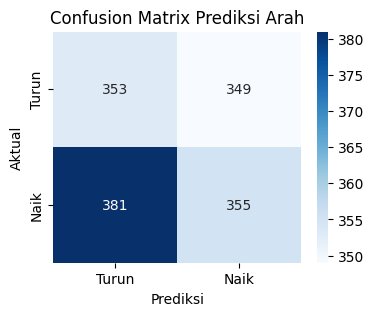

In [57]:
# (Pastikan test_predict_m2 sudah di-inverse dengan scaler_close)
test_predict_m2 = scaler_close.inverse_transform(test_predict_m2_scaled)

y_true = y_test_actual_m2.flatten()
y_pred = test_predict_m2.flatten()

# Prediksi arah (naik/turun)
true_dir = (y_true[1:] > y_true[:-1]).astype(int)
pred_dir = (y_pred[1:] > y_true[:-1]).astype(int)

cm = confusion_matrix(true_dir, pred_dir)
acc = accuracy_score(true_dir, pred_dir)

print("Confusion Matrix:\n", cm)
print(f"Akurasi prediksi arah: {acc:.4f}")
print(classification_report(true_dir, pred_dir, digits=4))

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Turun','Naik'], yticklabels=['Turun','Naik'])
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix Prediksi Arah")
plt.show()


## Model 3

In [58]:
# Clear session dan set seed
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)
K.clear_session()
gc.collect()

14693

In [59]:
# Clear session dan set seed
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)
K.clear_session()
gc.collect()

210

In [60]:
# Define model 3
model3 = Sequential()
model3.add(Conv1D(filters=256, kernel_size=2, activation='relu', padding='same', input_shape=(x_train.shape[1], num_features)))
model3.add(MaxPooling1D(pool_size=2))
model3.add(LSTM(150, return_sequences=True))
model3.add(Dropout(0.4))
model3.add(LSTM(150, return_sequences=False))
model3.add(Dropout(0.4))
model3.add(Dense(units=1, activation='sigmoid'))
model3.compile(optimizer='adam', loss='mse', metrics=[rmse()])

In [61]:
# Tampilkan ringkasan model
print("\nRingkasan Model 3:")
model3.summary()


Ringkasan Model 3:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 120, 256)          3328      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 60, 256)          0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 60, 150)           244200    
                                                                 
 dropout (Dropout)           (None, 60, 150)           0         
                                                                 
 lstm_1 (LSTM)               (None, 150)               180600    
                                                                 
 dropout_1 (Dropout)         (None, 150)               0         
                                    

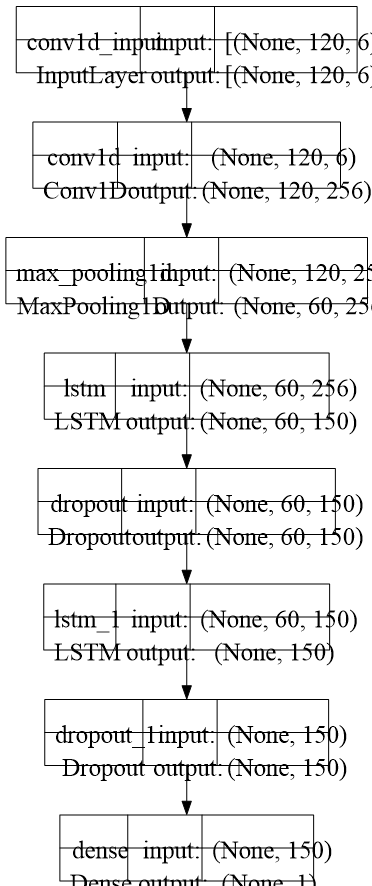

In [62]:
# Plot layers
tf.keras.utils.plot_model(model3, show_shapes=True, show_layer_names=True, to_file='model3_architecture.png')

In [63]:
# Callback EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Ukur waktu training Model 3
time_calc_start_m3 = time.time()

# Fit Model 3
print("\nMemulai training Model 3...")
history_m3 = model3.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=300,
    batch_size=64,
    # callbacks=[early_stop],
    verbose=1
)

fit_time_seconds_m3 = time.time() - time_calc_start_m3
print(f"\nFit time Model 3 = {fit_time_seconds_m3:.2f} seconds.")


Memulai training Model 3...
Epoch 1/300
96/96 [==============================] - 4s 17ms/step - loss: 0.0043 - root_mean_squared_error: 0.0652 - val_loss: 6.0599e-04 - val_root_mean_squared_error: 0.0246
Epoch 2/300
96/96 [==============================] - 1s 13ms/step - loss: 7.8713e-04 - root_mean_squared_error: 0.0281 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0343
Epoch 3/300
96/96 [==============================] - 1s 14ms/step - loss: 6.9554e-04 - root_mean_squared_error: 0.0264 - val_loss: 4.7773e-04 - val_root_mean_squared_error: 0.0219
Epoch 4/300
96/96 [==============================] - 1s 13ms/step - loss: 6.7250e-04 - root_mean_squared_error: 0.0259 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0412
Epoch 5/300
96/96 [==============================] - 1s 13ms/step - loss: 6.2607e-04 - root_mean_squared_error: 0.0250 - val_loss: 6.5782e-04 - val_root_mean_squared_error: 0.0256
Epoch 6/300
96/96 [==============================] - 1s 14ms/step - loss: 5.7388e-0


Visualisasi Loss Curve Model 3:


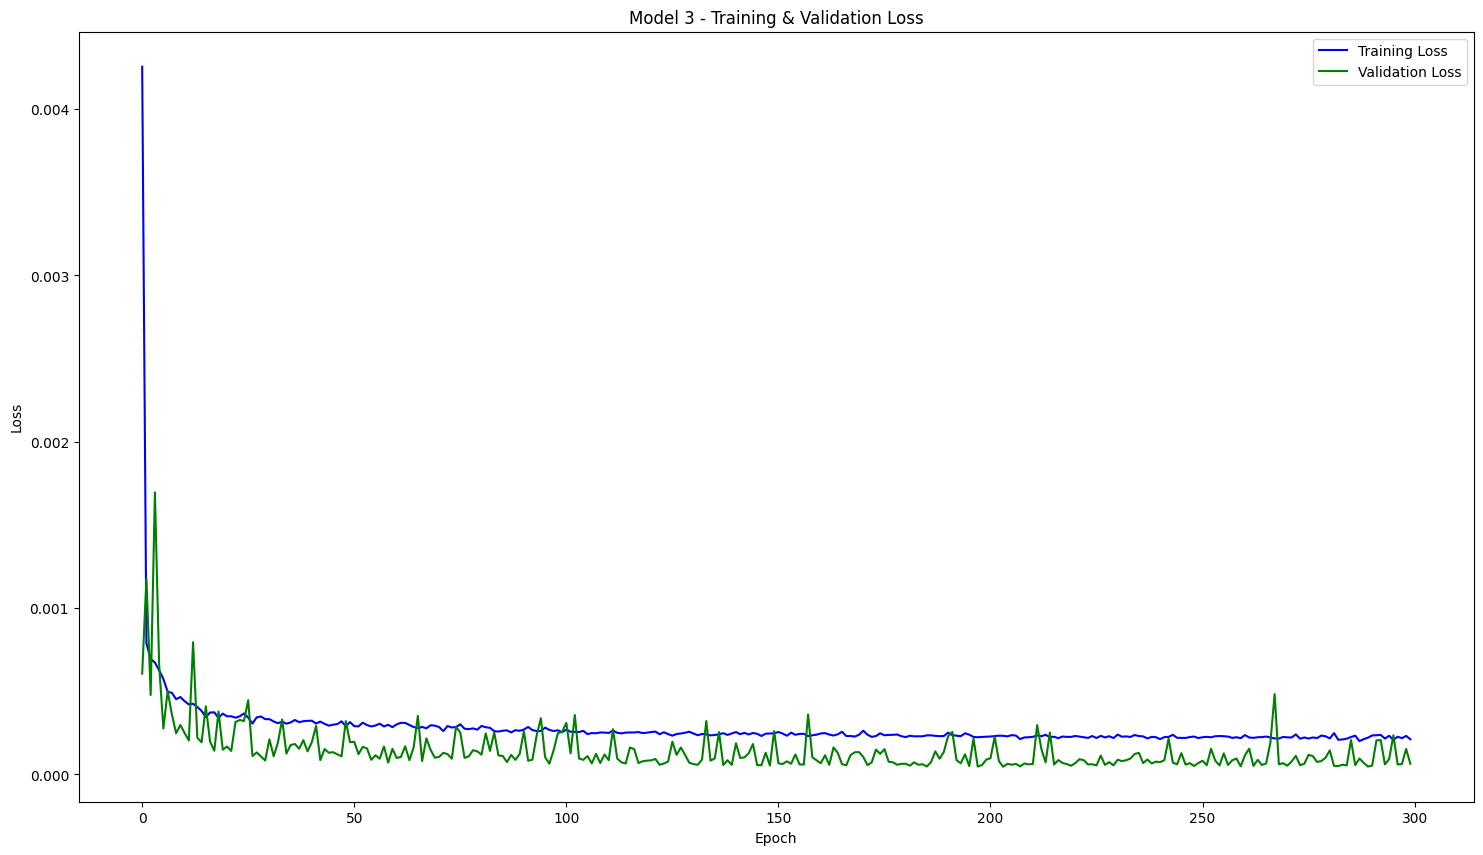

In [64]:
# Loss Curve Model 3
print("\nVisualisasi Loss Curve Model 3:")
plt.figure(figsize = (18,10))
plt.plot(history_m3.history['loss'],label='Training Loss',color='b')
plt.plot(history_m3.history['val_loss'],label='Validation Loss',color='g')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model 3 - Training & Validation Loss")
plt.legend()
plt.show()

In [65]:
# Evaluasi Model 3
print("\nEvaluasi Model 3 pada data training:")
model3.evaluate(x_train, y_train, batch_size=32)
print("\nEvaluasi Model 3 pada data testing:")
model3.evaluate(x_test, y_test, batch_size=32)


Evaluasi Model 3 pada data training:
192/192 [==============================] - 1s 5ms/step - loss: 5.8773e-05 - root_mean_squared_error: 0.0077

Evaluasi Model 3 pada data testing:
45/45 [==============================] - 0s 5ms/step - loss: 6.3739e-05 - root_mean_squared_error: 0.0080


[6.373902579071e-05, 0.007983672432601452]

In [66]:
# Prediksi dan Inverse Transform untuk Model 3
print("\nMelakukan prediksi dan Inverse Transform untuk Model 3...")
train_predict_m3_scaled = model3.predict(x_train)
test_predict_m3_scaled = model3.predict(x_test)


Melakukan prediksi dan Inverse Transform untuk Model 3...
45/45 [==============================] - 0s 4ms/step


In [67]:
# Inverse transform y_train dan y_test menggunakan scaler_close (sudah dilakukan di Model 1, tapi untuk kejelasan)
y_train_actual_m3 = scaler_close.inverse_transform(y_train.reshape(-1, 1)) 
y_test_actual_m3 = scaler_close.inverse_transform(y_test.reshape(-1, 1))

train_predict_m3_actual = scaler_close.inverse_transform(train_predict_m3_scaled)
test_predict_m3_actual = scaler_close.inverse_transform(test_predict_m3_scaled)

In [68]:
# Hitung metrik Model 3 data train
rmse_train_m3 = np.sqrt(metrics.mean_squared_error(y_train_actual_m3, train_predict_m3_actual)) # Menggunakan y_train_actual_m3/y_test_actual_m3
mse_train_m3 = metrics.mean_squared_error(y_train_actual_m3, train_predict_m3_actual)
r2_train_m3 = r2_score(y_train_actual_m3, train_predict_m3_actual)

# Hitung metrik Model 3 data test
rmse_test_m3 = np.sqrt(metrics.mean_squared_error(y_test_actual_m3, test_predict_m3_actual))
mse_test_m3 = metrics.mean_squared_error(y_test_actual_m3, test_predict_m3_actual)
r2_test_m3 = r2_score(y_test_actual_m3, test_predict_m3_actual)

In [69]:
print("\n--- Metrik Kinerja Model 3 ---")
print(f"Training RMSE: {rmse_train_m3:.4f}")
print(f"Training MSE : {mse_train_m3:.4f}")
print(f"Training R2  : {r2_train_m3:.4f}")
print(f"Testing RMSE : {rmse_test_m3:.4f}")
print(f"Testing MSE  : {mse_test_m3:.4f}")
print(f"Testing R2   : {r2_test_m3:.4f}")


--- Metrik Kinerja Model 3 ---
Training RMSE: 5.2374
Training MSE : 27.4298
Training R2  : 0.9991
Testing RMSE : 5.4541
Testing MSE  : 29.7474
Testing R2   : 0.9911



Visualisasi Prediksi vs Aktual Model 3 (Training Data):


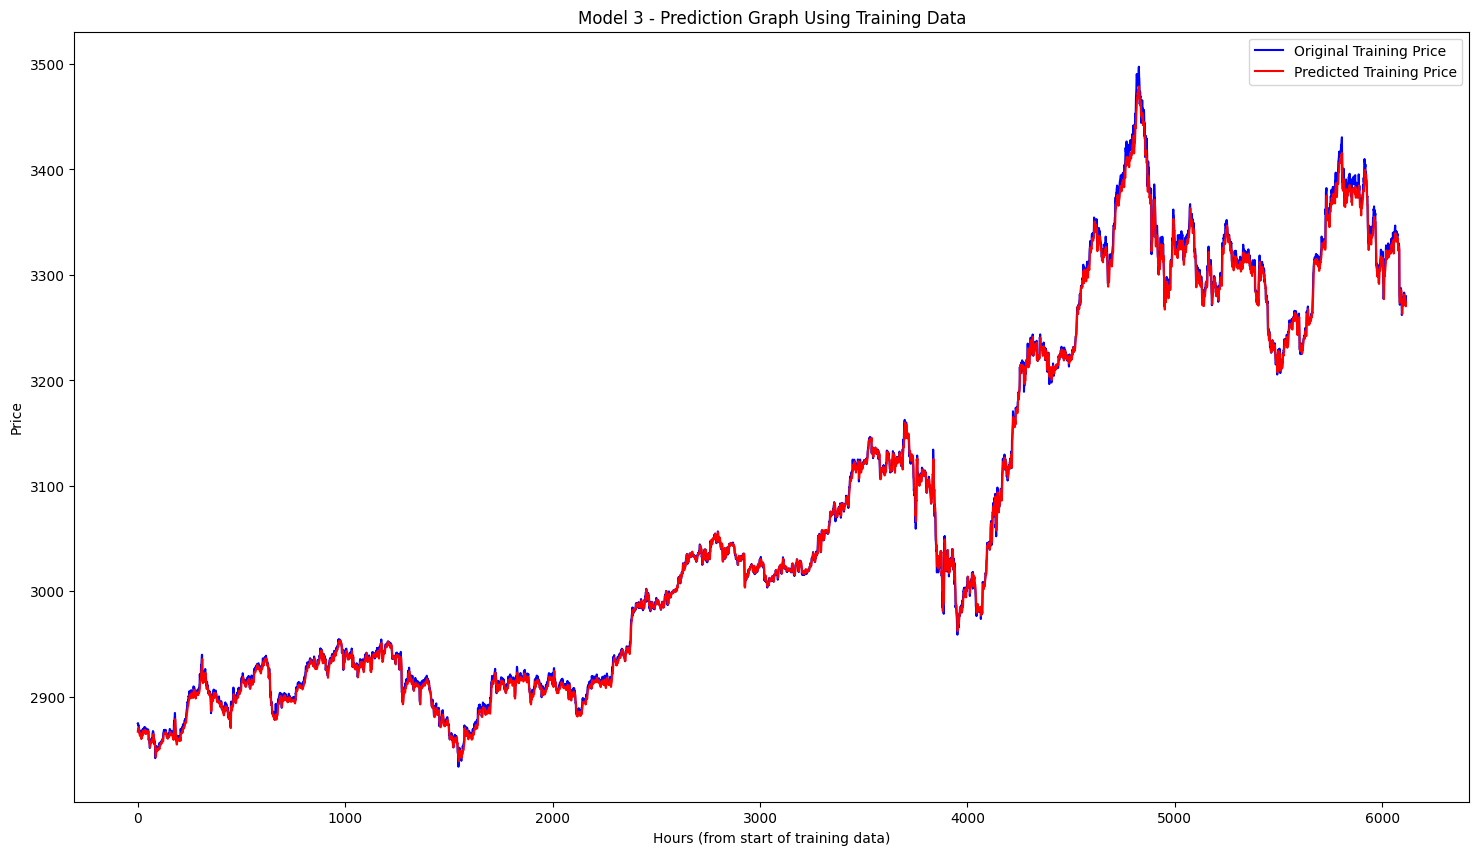

In [70]:
# Visualisasi Prediksi vs Aktual Model 3 (Training Data)
print("\nVisualisasi Prediksi vs Aktual Model 3 (Training Data):")
plt.figure(figsize=(18,10))
plt.plot(y_train_actual_m3, color = 'b', label = 'Original Training Price')
plt.plot(train_predict_m3_actual, color='red', label = 'Predicted Training Price')
plt.title("Model 3 - Prediction Graph Using Training Data")
plt.xlabel("Hours (from start of training data)")
plt.ylabel("Price")
plt.legend()
plt.show()


Visualisasi Prediksi vs Aktual Model 3 (Testing Data):


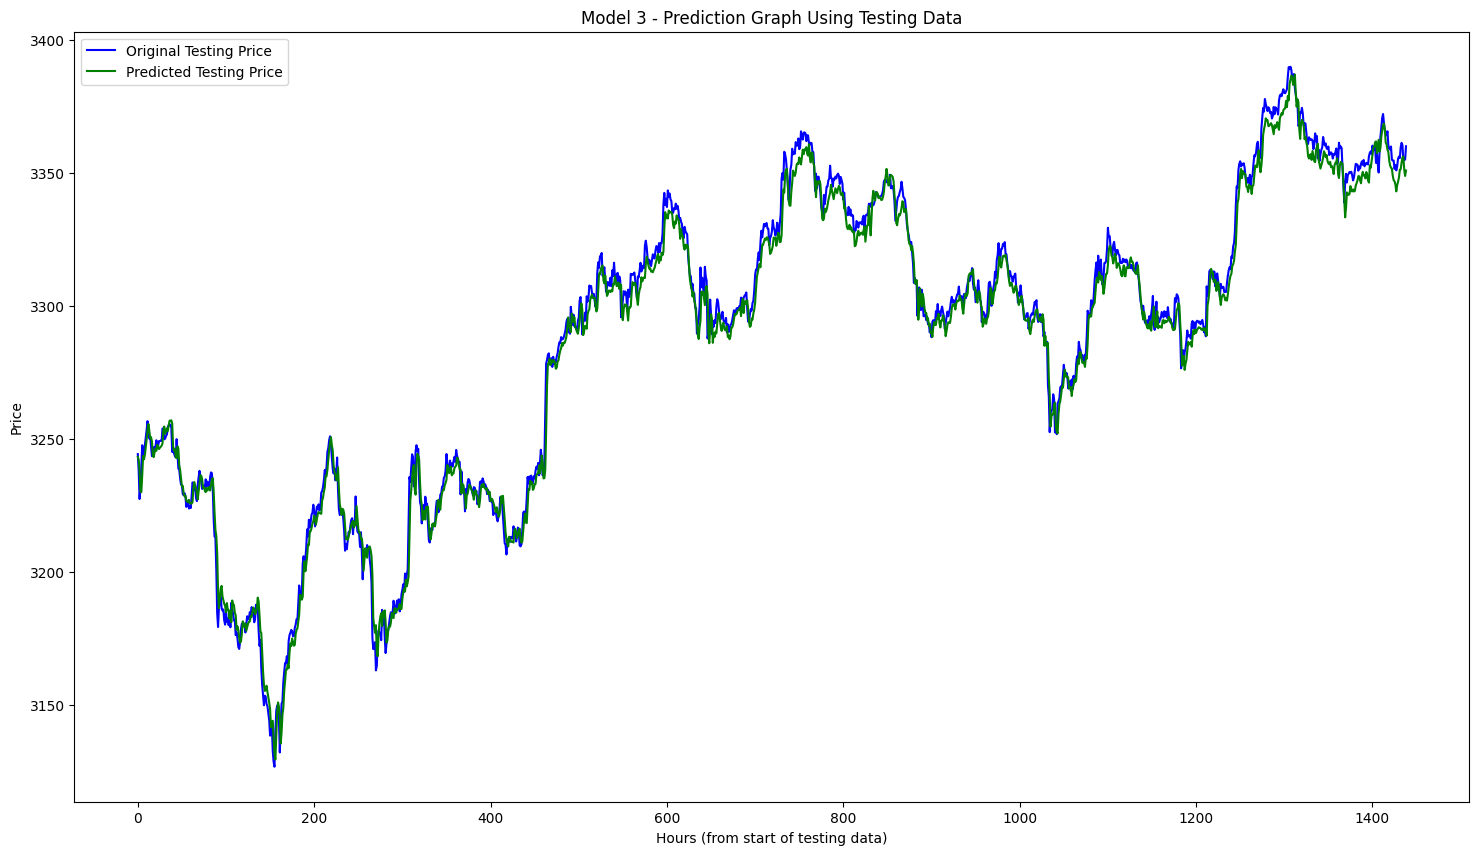

In [71]:
# Visualisasi Prediksi vs Aktual Model 3 (Testing Data)
print("\nVisualisasi Prediksi vs Aktual Model 3 (Testing Data):")
plt.figure(figsize=(18,10))
plt.plot(y_test_actual_m3, color = 'b', label = 'Original Testing Price')
plt.plot(test_predict_m3_actual, color='g', label = 'Predicted Testing Price')
plt.title("Model 3 - Prediction Graph Using Testing Data")
plt.xlabel("Hours (from start of testing data)")
plt.ylabel("Price")
plt.legend()
plt.show()

Confusion Matrix:
 [[564 138]
 [586 150]]
              precision    recall  f1-score   support

           0     0.4904    0.8034    0.6091       702
           1     0.5208    0.2038    0.2930       736

    accuracy                         0.4965      1438
   macro avg     0.5056    0.5036    0.4510      1438
weighted avg     0.5060    0.4965    0.4473      1438



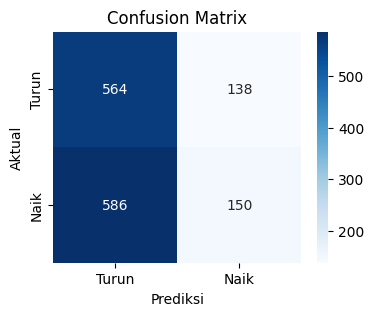

In [74]:
# y_test_actual_m3 = label aktual (sudah inverse)
# test_predict_m3  = hasil prediksi model, juga harus sudah inverse!

# (Pastikan test_predict_m3 sudah di-inverse dengan scaler_close)
test_predict_m3 = scaler_close.inverse_transform(test_predict_m3_scaled)

y_true = y_test_actual_m3.flatten()
y_pred = test_predict_m3.flatten()

# Prediksi arah (naik/turun)
true_dir = (y_true[1:] > y_true[:-1]).astype(int)
pred_dir = (y_pred[1:] > y_true[:-1]).astype(int)

cm = confusion_matrix(true_dir, pred_dir)
acc = accuracy_score(true_dir, pred_dir)

print("Confusion Matrix:\n", cm)
# print(f"Akurasi prediksi arah: {acc:.4f}")
print(classification_report(true_dir, pred_dir, digits=4))

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Turun','Naik'], yticklabels=['Turun','Naik'])
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix")
plt.show()


## Model Saving

In [73]:
# Save model
output_path = "M15.XAUUSD.onnx"
onnx_model = tf2onnx.convert.from_keras(model3, output_path=output_path)

# Quit MT5
mt5.shutdown()

True